# Parámetros globales del *Notebook*

In [1]:
# Para definir los path
import os

# Define si estamos ejecutando el Notebook en nuestro 
# ordenador ("local") o en Google Colab ("remote")
RUNNING_ENV = "local"

# Path que vamos a usar como base para el resto de paths
BASE_PATH = "./" if RUNNING_ENV == "local" else "/content/drive/MyDrive/Colab Notebooks/"

# Directorio en el que guardamos los scripts de python que usamos 
# como libreria propia
LIB_PATH = os.path.join(BASE_PATH, "lib")

# Directorio en el que guardamos los datos de entrenamiento y test
DATA_PATH = os.path.join(BASE_PATH, "data")

# Numero de procesos que queremos usar
NUM_WORKERS = 2

# Batch size que queremos usar para los dataloaders que usamos
DATALOADER_BACH_SIZE = 32

# Tamaño del conjunto de triples aleatorios
# Tiene que ser un multiplo de DATALOADER_BACH_SIZE para que
# la red tome correctamente los batches que espera
# TODO -- esto nunca lo he tenido que hacer asi que seguramente estemos
# haciendo algo mal
RANDOM_TRIPLETS_DATA_SIZE = DATALOADER_BACH_SIZE * 10

# Numero de epocas por las que queremos entrenar
TRAINING_EPOCHS = 1

# Margen para la funcion de perdida
MARGIN = 0.1

# Dimension del embedding que calculamos
EMBEDDING_DIMENSION = 2

# Numero de vecinos a usar en la adaptacion a clasificador
NUMBER_NEIGHBOURS = 3

# Autorización si estamos usando Google Drive

In [2]:
if RUNNING_ENV == "remote":
    from google.colab import drive
    drive.mount('/content/drive')

# Importando los módulos que vamos a usar

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torchvision
import torchvision.datasets as datasets

# Para poder usar ResNet18 preentrenado
import torchvision.models as models 
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime

# Cargamos en el Notebook todos los ficheros .py que definen nuestra propia libreria
# Usamos esta libreria para escribir el codigo base necesario para llevar a cabo ciertas
# tareas del notebook (como el bucle de entrenamiento) que no tienen interes mostrar
# en este notebook
!cp -r "$LIB_PATH"/* .

# Ahora que hemos cargado estos ficheros en el Notebook, importamos lo necesario
# de nuestra propia libreria
import core
import time
import copy
import board
import filesystem
from train_loggers import ClassificationLogger, SilentLogger, TripletLogger, TrainLogger
from models.resnet import *
from visualizations import *
from custom_loss import triplet_loss_batch_hard
from tqdm.notebook import tqdm

from sklearn.neighbors import KNeighborsClassifier

# Funciones comunes que vamos a usar en el notebook

In [4]:
def show_learning_curve(training_history: dict):
    # Tomamos las dos funciones de perdida
    loss = training_history['loss']
    val_loss = training_history['val_loss']
    
    # Mostramos las graficas
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()

# Carga del conjunto de datos

- Cargamos los datos de entrenamiento y test
- Además, separamos train en train y validación

In [5]:
# Transformaciones que queremos aplicar al cargar los datos
# Ahora solo pasamos las imagenes a tensores, pero podriamos hacer aqui normalizaciones
transform = transforms.Compose([
    transforms.ToTensor(),
    # TODO -- aqui podemos añadir la normaliazcion de datos
])

# Cargamos el dataset usando torchvision, que ya tiene el conjunto
# preparado para descargar
train_dataset = torchvision.datasets.FashionMNIST(
    root = DATA_PATH,
    train = True,
    download = True,
    transform = transform,
)

test_dataset = torchvision.datasets.FashionMNIST(
    root = DATA_PATH,
    train = False,
    download = True,
    transform = transform,
)

# Separamos train en train y validacion
train_dataset, validation_dataset = core.split_train_test(train_dataset, 0.8)

# Data loaders para acceder a los datos
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = DATALOADER_BACH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
    pin_memory = True,
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size = DATALOADER_BACH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
    pin_memory = True,
)

test_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size = DATALOADER_BACH_SIZE,
  shuffle = True,
  num_workers = NUM_WORKERS,
  pin_memory = True,
)

# Definiendo las clases con las que vamos a trabajar

In [6]:
# Clases con las que vamos a trabajar
# Esta lista especifica la relacion numero -> nombre de la forma
# classes[numero] = nombre
classes = (
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
)

# Análisis Exploratorio de datos

Mostramos algunas imágenes con sus clases para asegurar que hemos cargado correctamente las imágenes del conjunto de datos:

La clase obtenida es: Trouser


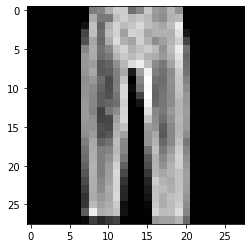

La clase obtenida es: Sandal


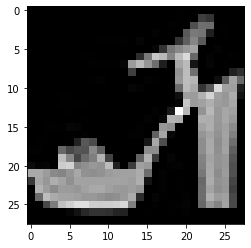

La clase obtenida es: T-shirt/top


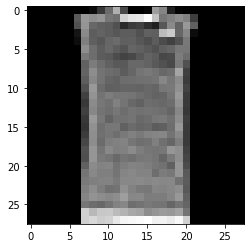

La clase obtenida es: Pullover


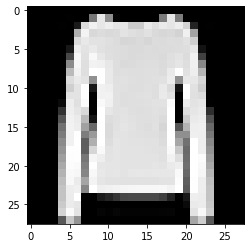

La clase obtenida es: Sandal


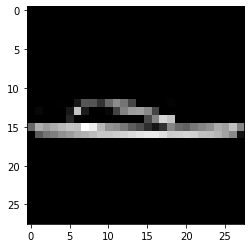

In [7]:
imgs_to_show = 5

for _ in range(imgs_to_show):

    # Cargamos un batch de imagenes
    images, images_classes = next(iter(train_loader))

    # Nos quedamos con la primera imagen del batch
    img, img_class = images[0], images_classes[0]

    # Mostramos alguna informacion de la imagen
    print(f"La clase obtenida es: {classes[img_class]}")

    # Re-escalamos y mostramos la imagen
    img = img.reshape((28, 28))
    show_img(img, color_format_range = (-1.0, 1.0))

Mostramos ahora unas cuantas imágenes de forma simultánea:

Mostramos ahora los tamaños del dataset:

In [8]:
print(f"Tenemos {len(train_dataset)} imágenes de entrenamiento")
print(f"Tenemos {len(test_dataset)} imágenes de test")

Tenemos 48000 imágenes de entrenamiento
Tenemos 10000 imágenes de test


# Definiendo el modelo base

- A continuación, definimos el modelo que vamos a usasr como base para nuestra red siamesa
- Usaremos el modelo pre-entrenado ResNet18, pre-entrenado en ImageNet

In [9]:
class ResNet18(torch.nn.Module):
    def __init__(self):
        
        super(ResNet18, self).__init__()
        
        # Tomamos el modelo pre-entrenado ResNet18
        self.pretrained = models.resnet18(pretrained=True)
        
        # Cambiamos la primera convolucion para que en vez
        # de tres canales acepte un canal para las imagenes
        # de entrada
        self.pretrained.conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Cambiamos la ultima capa fc Linear(in_features=512, out_features=1000, bias=True)
        # para calcular un embedding de dimension mucho menor
        # TODO -- comentar en la memoria el cambio de ERROR que hacer esto nos ha supuesto
        self.pretrained.fc = nn.Linear(in_features=512, out_features=EMBEDDING_DIMENSION, bias=True)
        
        # Por defecto siempre realizamos la permutacion del tensor de entrada
        self.should_permute = True

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # Tenemos como entrada tensores (1, DATALOADER_BACH_SIZE, 28, 28) y 
        # queremos tensores (DATALOADER_BACH_SIZE, 1, 28, 28) para poder trabajar
        # con la red pre-entrenada
        # Usamos permute en vez de reshape porque queremos que tambien funcione al
        # realizar inferencia con distintos tamaños de minibatch (ie. 1)
        if self.should_permute is True:
            x = torch.permute(x, (1, 0, 2, 3))

        # Usamos directamente la red pre-entrenada para hacer el forward
        x = self.pretrained.forward(x)
        
        return x
    
    def set_permute(self, should_permute: bool):
        self.should_permute = should_permute

# Generación de triples

- Para entrenar la red siamesa, necesitamos dar triples con los que computar el *triplet loss*
- Por ello, es necesaria una fase previa de *triplets mining*
- En todos los casos, crearemos *Datasets* de *Pytorch* para representar la creación de los triples
- Hacemos esto basándonos el la [documentación oficial de Pytorch](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

## Generación de triples aleatorios

- Es la forma más sencilla y directa para generar triples
- Usaremos esta generación como baseline para más tarde realizar comparaciones

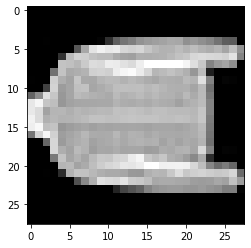

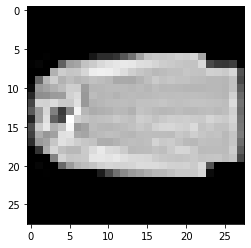

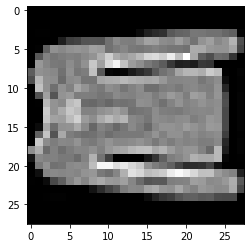

In [10]:
from torch.utils.data import RandomSampler

class RandomTriplets(Dataset):
    """
    Dataset en el que los elementos son triples obtenidos de forma aleatoria
    """

    def __init__(self, base_data: Dataset, custom_len: int, transform = None):
        self.base_data = base_data
        self.custom_len = custom_len
        self.transform = transform
        self.random_sampler = RandomSampler(self.base_data, replacement=True, num_samples=1, generator=None)
        
        # Por motivos de eficiencia, pre-computamos una lista de listas, de forma
        # que tengamos disponibles las listas con las posiciones de cada clase por
        # separado.
        self.posiciones_clases = self.__precompute_list_of_classes()

    def __len__(self):
        """
        Devolvemos el tamaño del dataset
        Como estamos generando triples aleatorios, devolvemos el tamaño definido
        por parametro
        """
        return self.custom_len

    def __getitem__(self, idx) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Funcion que es llamada cuando se hace dataset[idx]
        En vez de devolver una imagen (que es lo comun en esta clase dataset), 
        devolvemos un triple (anchor, positive, negative) aleatorio
        """

        # Hacemos esto por temas de eficiencia
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Tomamos una imagen aleatoria que sera el ancla
        anchor, anchor_class = self.base_data[next(iter(self.random_sampler))]

        # Tomamos una imagen de la misma clase, que sera la positiva, de forma aleatoria
        random_index = np.random.choice(self.posiciones_clases[anchor_class])
        positive, positive_class = self.base_data[random_index]

        # Tomamos una imagen de otra clase, que sera la negativa
        # Empiezo tomando una clase que no sea la del anchor
        posible_classes = list(range(10))
        posible_classes.remove(anchor_class)
        negative_class = np.random.choice(posible_classes)

        # Ahora tomamos un indice aleatorio de esta clase negativa
        random_index = np.random.choice(self.posiciones_clases[negative_class])
        negative, negative_class = self.base_data[random_index]
        
        # Generamos ahora el triple
        triplet = [anchor, positive, negative]

        # Aplicamos la transformacion dada al dataset al ejemplo que devolvemos
        if self.transform:
            triplet = [self.transform(np.array(img)) for img in triplet]

        return triplet

    def __precompute_list_of_classes(self) -> List[List[int]]:
        """
        Calcula la lista con las listas de posiciones de cada clase por separado
        """
        # Inicializamos la lista de listas
        posiciones_clases = [[] for _ in range(10)]

        # Recorremos el dataset y colocamos los indices donde corresponde
        for idx, element in enumerate(self.base_data):
            _, img_class = element
            posiciones_clases[img_class].append(idx)

        return posiciones_clases

    
class CustomReshape(object):
    """Pasamos la imagen de (28, 1, 28) a (28, 28)"""

    def __call__(self, image):
        image = image.reshape(28, 28)
        return image


# Antes de modificar la base de datos para convertirla a triples
# la guardamos, porque mas adelante nos hara falta
old_train_dataset = train_dataset

# Necesitamos hacer reshape de las imagenes para que
# sean (28, 28) y no (28, 1, 28)
transform = transforms.Compose([
    transforms.ToTensor(),
    
    # Hacemos reshape de las imagenes para
    # que sean tensores (28, 28)
    CustomReshape(),
])

# Generamos los triples aleatorios para training
random_triplets_train = RandomTriplets(
    base_data = train_dataset,
    custom_len = RANDOM_TRIPLETS_DATA_SIZE,
    transform = transform,
)

train_loader = torch.utils.data.DataLoader(
    random_triplets_train,
    batch_size = DATALOADER_BACH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
    pin_memory = True,
)

# Generamos los triples aleatorios para validacion
random_triplets_validation = RandomTriplets(
    base_data = validation_dataset,
    custom_len = RANDOM_TRIPLETS_DATA_SIZE,
    transform = transform,
)

validation_loader = torch.utils.data.DataLoader(
    random_triplets_validation,
    batch_size = DATALOADER_BACH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
    pin_memory = True,
)

# Generamos los triples aleatorios para test
random_triplets_test = RandomTriplets(
    base_data = test_dataset,
    custom_len = RANDOM_TRIPLETS_DATA_SIZE,
    transform = transform,
)

test_loader = torch.utils.data.DataLoader(
    random_triplets_test,
    batch_size = DATALOADER_BACH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
    pin_memory = True,
)


# TODO -- esto habria que borrarlo, esta aqui para hacer pruebas
#Visualizamos un triple
custom_triplet = random_triplets_train[2]
for i in custom_triplet :
    show_img(i, color_format_range = (-1.0, 1.0))


# Definición de la función de pérdida

In [11]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:       
       
        distance_positive = self.__euclidean_distance(anchor, positive)
        distance_negative = self.__euclidean_distance(anchor, negative)

        # Usamos Relu para que el error sea cero cuando la resta de las distancias
        # este por debajo del margen. Si esta por encima del margen, devolvemos la
        # identidad de dicho error. Es decir, aplicamos Relu a la formula que 
        # tenemos debajo
        loss = torch.relu(distance_positive - distance_negative + self.margin)

        return loss

    def __euclidean_distance(self, first: torch.Tensor, second: torch.Tensor) -> float:
        return ((first - second) * (first - second)).sum()

class TripletLossCustom(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLossCustom, self).__init__()
        self.margin = margin
        self.base_loss = TripletLoss(self.margin)
    
    def forward(self, batch: torch.Tensor) -> torch.Tensor:
        losses = torch.tensor(
            [self.base_loss(current[0], current[1], current[2]) for current in batch], 
            requires_grad=True
        )
        return losses.mean()

# Entrenamiento del modelo

In [12]:
net = ResNet18()

# TODO -- fijar bien los parametros
parameters = dict()
parameters["epochs"] = TRAINING_EPOCHS
parameters["lr"] = 0.001
parameters["criterion"] = TripletLossCustom(MARGIN)

# Definimos el logger que queremos para el entrenamiento
logger = TripletLogger(
    net = net,
    iterations = 10 * DATALOADER_BACH_SIZE,
    loss_func = parameters["criterion"],
)

print(net)

ResNet18(
  (pretrained): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [13]:
training_history = core.train_model(
    net = net,
    path = os.path.join(BASE_PATH, "tmp"),
    parameters = parameters,
    train_loader = train_loader,
    validation_loader = validation_loader,
    name = "SiameseNetwork",
    logger = logger,
    snapshot_iterations = None
)

==> Training on device cuda:0

Finished training


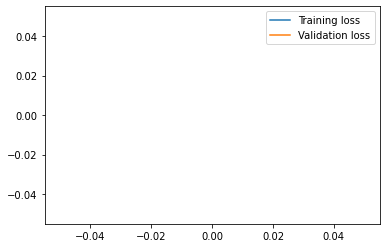

In [14]:
show_learning_curve(training_history)

# Evaluación del modelo

- Mostramos algunas métricas fundamentales sobre el conjunto de

In [15]:
core.test_model(net, test_loader, parameters["criterion"])

Test Loss: 0.03912247717380524


# Adaptación del modelo para usarlo como clasificador

- Nuestro modelo genera un *embedding*
- Adaptamos el modelo para que, a partir de dicho embedding, podamos usarlo como un clasificador

In [16]:
class EmbeddingToClassifier:
    """
    Clase que toma un modelo que calcula embeddings y lo convierte
    a un modelo que sirve para una tarea de clasificacion
    
    Usamos K-NN para el modelo de clasificacion
    """
    
    def __init__(self, embedder: nn.Module, k: int, data_loader):
        
        # El modelo que calcula los embeddings
        self.embedder = embedder
         
        # Dataloader que representa el dataset que usamos para k-nn
        self.data_loader = data_loader
        
        # Tomamos el dispositivo en el que esta el modelo y los
        # datos, porque nos va a hacer falta durante todo el codigo
        self.device = core.get_device()
        
        # Calculamos todos los embeddings de los puntos
        self.dataset_embedded = self.__calculate_embedding()
        
        # Modelo de clasificacion k-nn
        self.k = k
        self.knn = self.__fit_knn()
                
    def predict(self, img) -> int:
        
        # Ponemos la red en modo evaluacion
        self.embedder.eval()
        
        # Tenemos una unica imagen, lo que queremos es
        # tener un batch de una imagen para que la red
        # pueda trabajar con ello
        single_img_batch = torch.Tensor(img)
        
        # Calculamos el embedding de la imagen
        img_embedding = self.embedder(single_img_batch[None, ...].to(self.device))
        
        # Pasamos el embedding a cpu que es donde esta 
        # el modelo knn de scikit learn
        img_embedding = img_embedding.cpu().detach().numpy() 
        
        # Antes de salir de la funcion volvemos a poner
        # a la red en modo entrenamiento
        self.embedder.train()
        
        # Usamos dicho embedding para clasificar con knn
        return self.knn.predict(img_embedding)
            
    def __calculate_embedding(self):
        """Dado el conjunto de imagenes con sus etiquetas, calculamos
        el conjunto de embedding con sus etiquetas"""
        
        embedded_imgs = []
        labels = []

        
        # Por motivos que desconocemos, ahora los tensores vienen
        # en el formato que espera la red, asi que no tenemos que
        # realizar la permutacion del tensor
        self.embedder.set_permute(False)
        
        for img, img_class in self.data_loader:
            
            # TODO -- esto hay que borrarlo
            if np.random.rand() < 0.01:
                break
            
            # Calculamos el embedding de la imagen
            img_embedding = self.embedder(img.to(self.device))
            
            # Añadimos el embedding asociado a la etiqueta
            embedded_imgs.append(img_embedding)
            labels.append(img_class)
        
        # Antes de devolver los datos, volvemos a colocar la opcion
        # de que permute los tensores
        self.embedder.set_permute(True)

        return embedded_imgs, labels

    def __fit_knn(self):
        
        # Separamos los datos segun espera sklearn
        x = self.dataset_embedded[0]
        y = self.dataset_embedded[1]
        
        # Pasamos de una lista de sublistas (por los minibatches)
        # a una lista. Tomamos la idea de:
        # https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists
        x = [item for sublist in x for item in sublist]
        y = [item for sublist in y for item in sublist]
        
        # Forzamos a usar la memoria RAM (podrian estar los datos
        # en memoria GPU) 
        x = np.array([element.cpu().detach().numpy() for element in x])
        y = np.array([element.cpu().detach().numpy() for element in y])
        
        knn = KNeighborsClassifier(n_neighbors = self.k)
        knn.fit(x, y)
        return knn

Para la adaptación al clasificador, necesitamos tomar las imágenes junto a sus clases. Antes teníamos conjuntos de triples sin clases, ahora recuperamos la información original necesaria para la adaptación

In [17]:
# Cargamos el dataset usando torchvision, que ya tiene el conjunto
# preparado para descargar
train_dataset = old_train_dataset

# Data loaders para acceder a los datos
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = DATALOADER_BACH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
    pin_memory = True,
)

classifier = EmbeddingToClassifier(net, k = NUMBER_NEIGHBOURS, data_loader = train_loader)

Evaluamos este clasificador en el conjunto de test:

In [18]:
img, img_class = train_dataset[0]
predicted_class = classifier.predict(img)
print(img_class, predicted_class)

2 [0]


## Evaluación del clasificador obtenido

- Ahora que hemos adaptado el modelo para usarlo como clasificador, podemos consultar ciertas métricas de clasificación

In [19]:
# TODO -- implementar las métricas de clasificación